### 0. Imports and setup

In [13]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import rgb2hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [14]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [15]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 4 or i > 12:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    transforms.RandomRotation(45),
    random_color,
    Add_dimension,
])

# Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)

indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [16]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


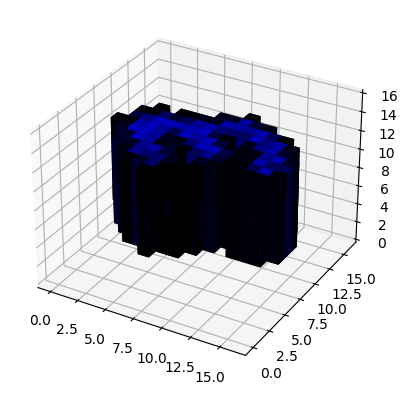

In [17]:
plot_img(next(iter(mnist_train_a))[0])

### 3. Preparation for the training

In [18]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [19]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [20]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

In [21]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [22]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

In [23]:
def save_model(e, t, F, o_t, o_F, l_t, l_F, path):
    torch.save({
                'epoch': e,
                'T_state_dict': t.state_dict(),
                'f_state_dict': F.state_dict(),
                'T_optimizer_state_dict': o_t.state_dict(),
                'f_optimizer_state_dict': o_F.state_dict(),
                'T_loss': l_t,
                'f_loss': l_F
                }, path)

def load_model(F, t, o_t, o_F, path):
    checkpoint = torch.load(path)

    F.load_state_dict(checkpoint["f_state_dict"])
    t.load_state_dict(checkpoint["T_state_dict"])
    o_F.load_state_dict(checkpoint["f_optimizer_state_dict"])
    o_t.load_state_dict(checkpoint["T_optimizer_state_dict"])
    
    return checkpoint["epoch"], F, t, o_F, o_t, checkpoint["T_loss"], checkpoint["f_loss"]

step, f, T, T_opt, f_opt, T_loss, f_loss = load_model(f, T, T_opt, f_opt, "weights/OT_30000.pt")

### 4. Training loop

In [24]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

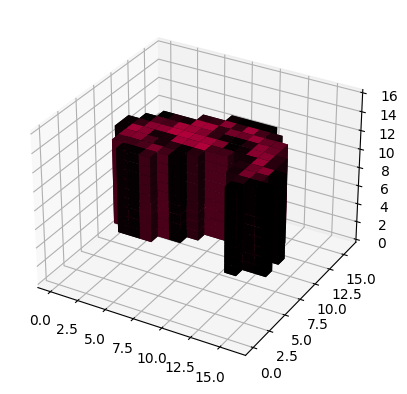

  0%|          | 0/3001 [00:00<?, ?it/s]

T_loss: -110.50635528564453;  f_loss: 6.06842041015625


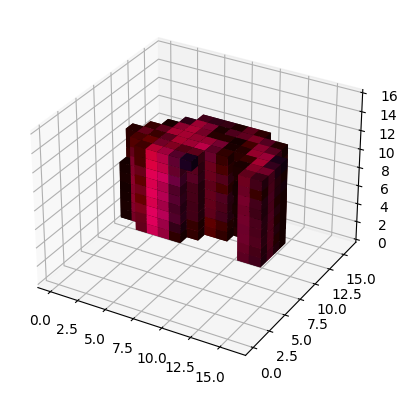

  3%|▎         | 100/3001 [01:08<33:06,  1.46it/s]

T_loss: -1.3198954367702419e+25;  f_loss: -4.110199751568548e+23


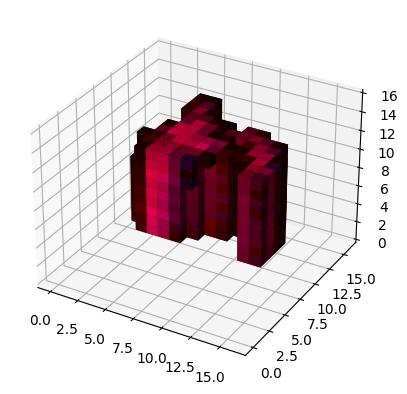

  7%|▋         | 200/3001 [02:18<32:30,  1.44it/s]

T_loss: -1.927576611665516e+25;  f_loss: 1.4275335719461426e+24


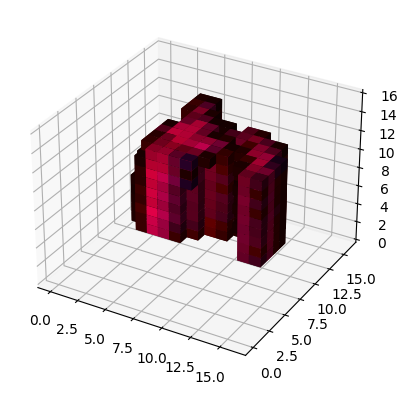

 10%|▉         | 300/3001 [03:28<31:13,  1.44it/s]

T_loss: -2.458218649285757e+25;  f_loss: 2.0425756894797297e+24


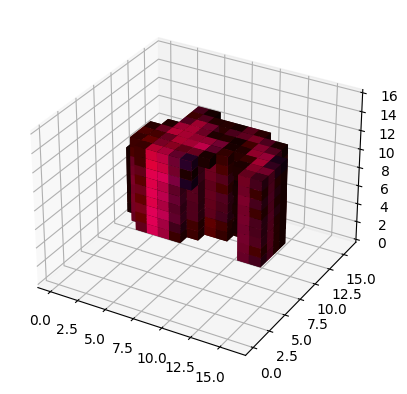

 13%|█▎        | 400/3001 [04:38<30:12,  1.44it/s]

T_loss: -2.6614676425015e+25;  f_loss: 5.568048241556823e+24


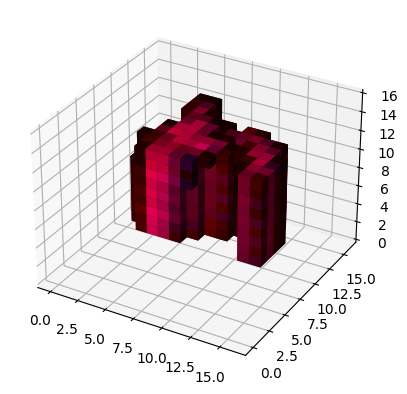

 17%|█▋        | 500/3001 [05:48<29:11,  1.43it/s]

T_loss: -2.9977095900381564e+25;  f_loss: -3.816165568562645e+24


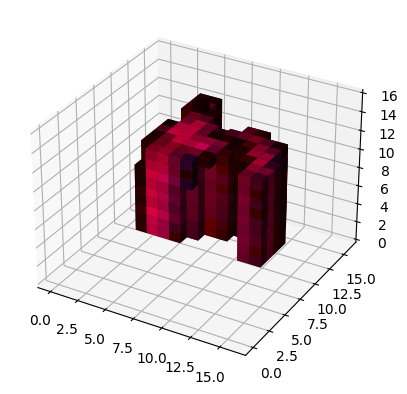

 20%|█▉        | 600/3001 [06:58<27:52,  1.44it/s]

T_loss: -3.3914387402218204e+25;  f_loss: 2.700877727709175e+24


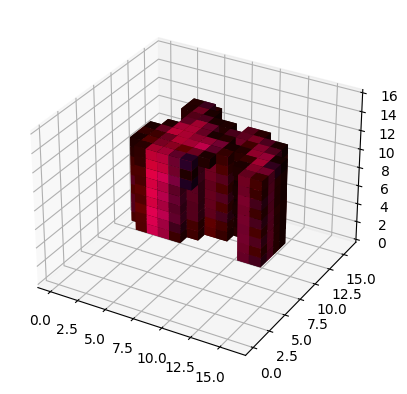

 23%|██▎       | 700/3001 [08:07<26:31,  1.45it/s]

T_loss: -3.8517590224214695e+25;  f_loss: 3.848451982377655e+21


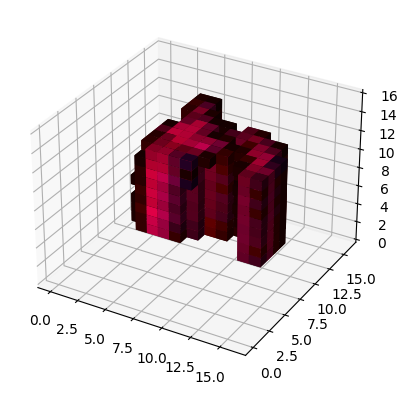

 27%|██▋       | 800/3001 [09:17<25:29,  1.44it/s]

T_loss: -3.7530684804585215e+25;  f_loss: 4.551683371641629e+24


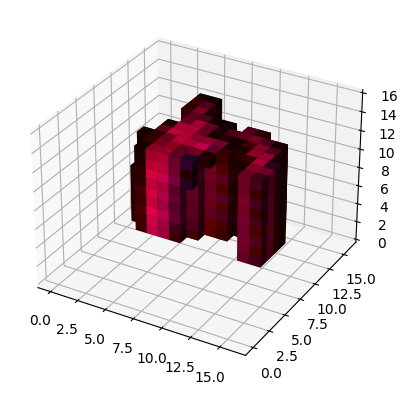

 30%|██▉       | 900/3001 [10:27<24:19,  1.44it/s]

T_loss: -4.072097540515699e+25;  f_loss: 9.429929453620139e+23


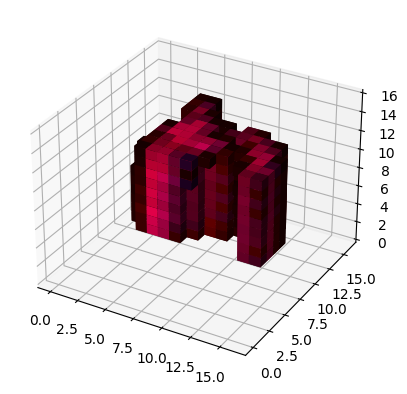

 33%|███▎      | 1000/3001 [11:37<23:09,  1.44it/s]

T_loss: -4.487269647179245e+25;  f_loss: 8.418955644660487e+23


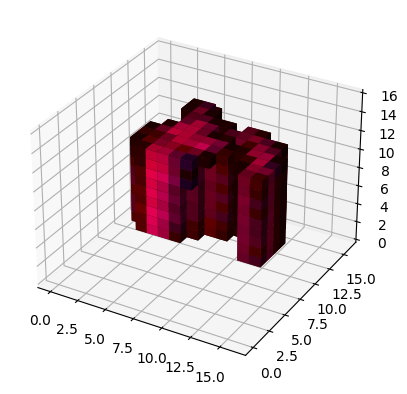

 37%|███▋      | 1100/3001 [12:47<21:52,  1.45it/s]

T_loss: -4.7468167198021435e+25;  f_loss: -6.937497628100872e+23


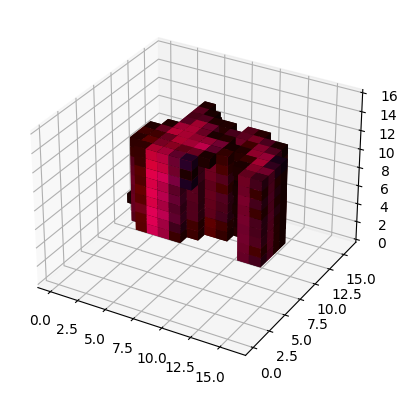

 40%|███▉      | 1200/3001 [13:57<20:51,  1.44it/s]

T_loss: -4.777897638891937e+25;  f_loss: 3.8937848559387964e+24


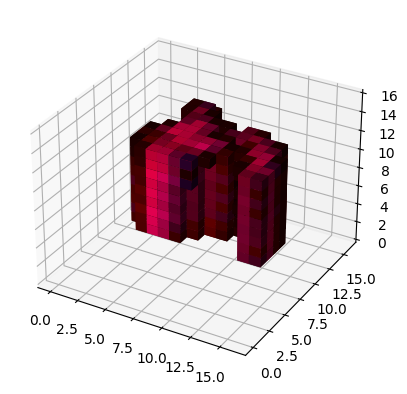

 43%|████▎     | 1300/3001 [15:07<19:41,  1.44it/s]

T_loss: -5.228135622533799e+25;  f_loss: 1.1490753584674785e+24


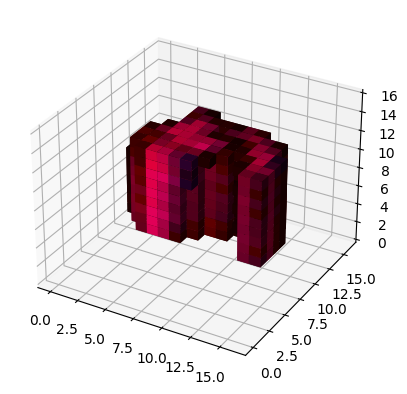

 47%|████▋     | 1400/3001 [16:17<18:30,  1.44it/s]

T_loss: -5.006830956218709e+25;  f_loss: 2.304957565498156e+24


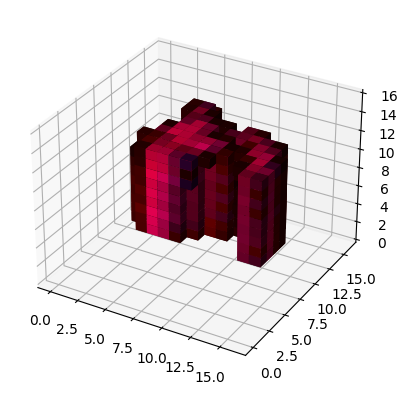

 50%|████▉     | 1500/3001 [17:27<17:23,  1.44it/s]

T_loss: -5.479309256853039e+25;  f_loss: 7.033771185421563e+24


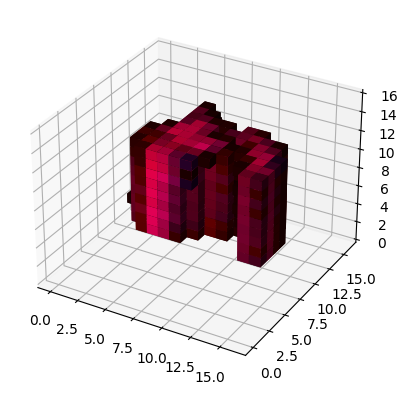

 53%|█████▎    | 1600/3001 [18:37<16:18,  1.43it/s]

T_loss: -5.991943352324224e+25;  f_loss: -2.8211528049127703e+23


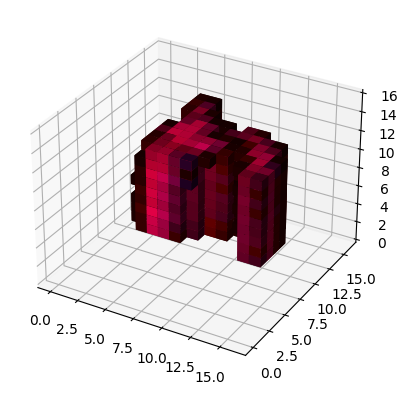

 57%|█████▋    | 1700/3001 [19:47<14:55,  1.45it/s]

T_loss: -6.1229396771834595e+25;  f_loss: 3.5678816167025514e+24


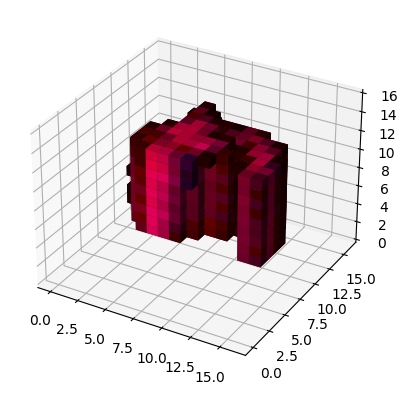

 60%|█████▉    | 1800/3001 [20:56<13:52,  1.44it/s]

T_loss: -6.240032229865738e+25;  f_loss: -6.957207974143631e+24


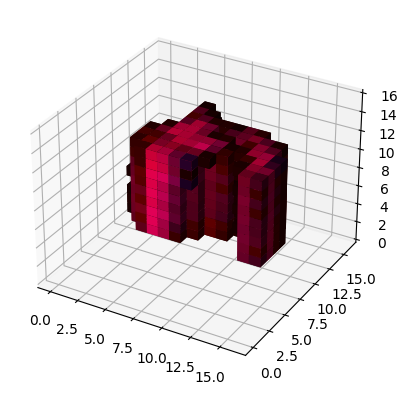

 63%|██████▎   | 1900/3001 [22:06<12:45,  1.44it/s]

T_loss: -6.390055910068403e+25;  f_loss: 2.8334660065819714e+24


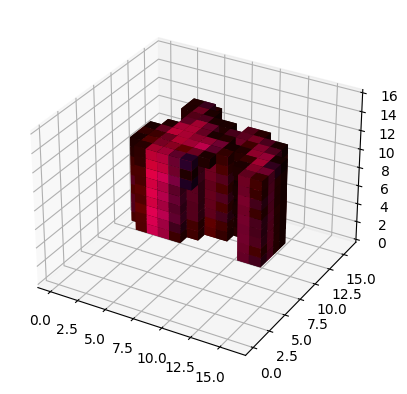

 67%|██████▋   | 2000/3001 [23:16<11:35,  1.44it/s]

T_loss: -6.6252329890955245e+25;  f_loss: 8.273410833918918e+24


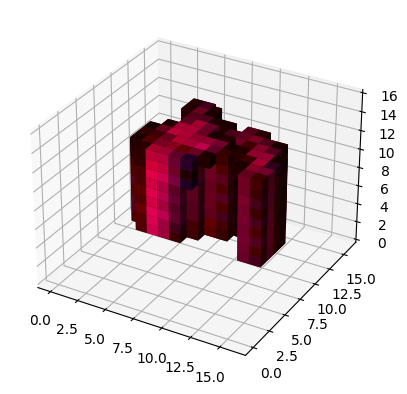

 70%|██████▉   | 2100/3001 [24:27<10:25,  1.44it/s]

T_loss: -7.164640688915291e+25;  f_loss: -1.6639378206227674e+24


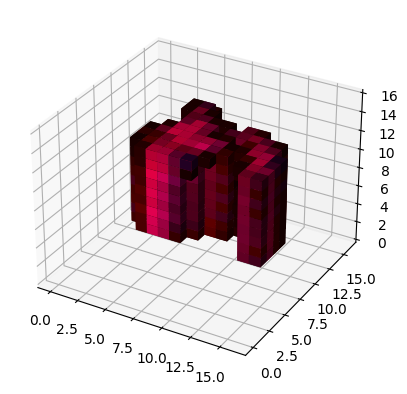

 73%|███████▎  | 2200/3001 [25:37<09:13,  1.45it/s]

T_loss: -7.326986794159194e+25;  f_loss: 3.294948203073963e+24


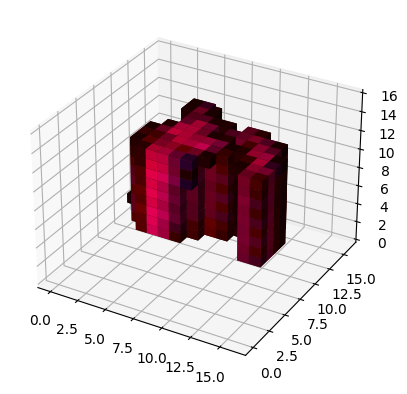

 77%|███████▋  | 2300/3001 [26:47<08:07,  1.44it/s]

T_loss: -7.341682853994117e+25;  f_loss: 5.041781079877963e+24


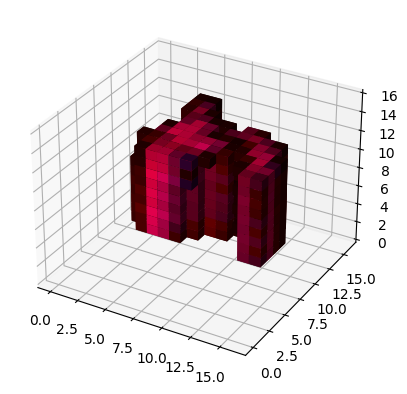

 80%|███████▉  | 2400/3001 [27:57<06:57,  1.44it/s]

T_loss: -7.3545227102066224e+25;  f_loss: 6.499484301756658e+24


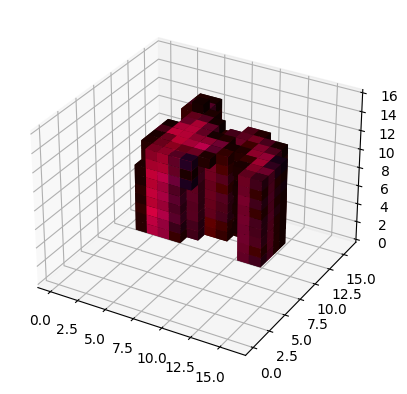

 83%|████████▎ | 2500/3001 [29:06<05:47,  1.44it/s]

T_loss: -8.461311213728131e+25;  f_loss: 6.392696100313953e+24


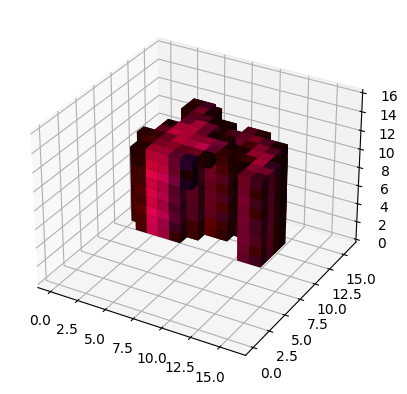

 87%|████████▋ | 2600/3001 [30:16<04:39,  1.44it/s]

T_loss: -7.99481888154572e+25;  f_loss: 3.4669917616774154e+24


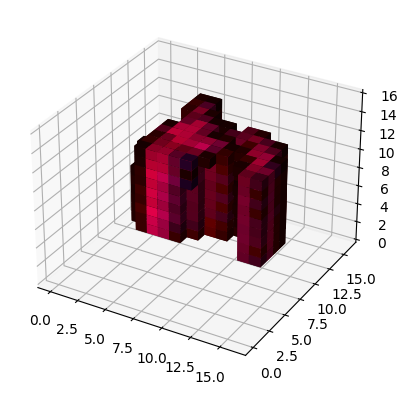

 90%|████████▉ | 2700/3001 [31:26<03:29,  1.43it/s]

T_loss: -8.339125515007101e+25;  f_loss: 2.18160418787726e+23


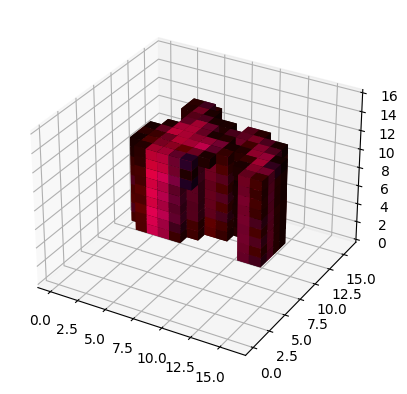

 93%|█████████▎| 2800/3001 [32:36<02:19,  1.44it/s]

T_loss: -8.945019892154536e+25;  f_loss: 1.9553733185572862e+24


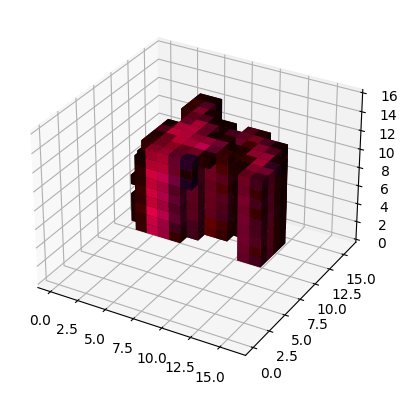

 97%|█████████▋| 2900/3001 [33:46<01:10,  1.44it/s]

T_loss: -8.585678239935877e+25;  f_loss: -1.5493531027973095e+25


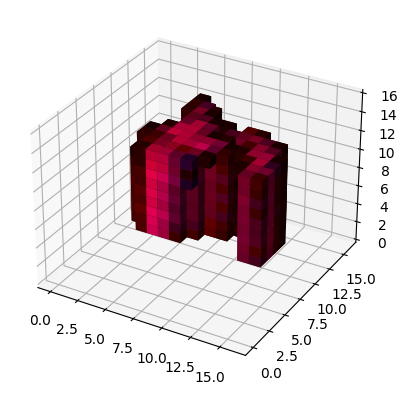

100%|█████████▉| 3000/3001 [34:56<00:00,  1.44it/s]

T_loss: -8.907051881164823e+25;  f_loss: 6.712244436216805e+24


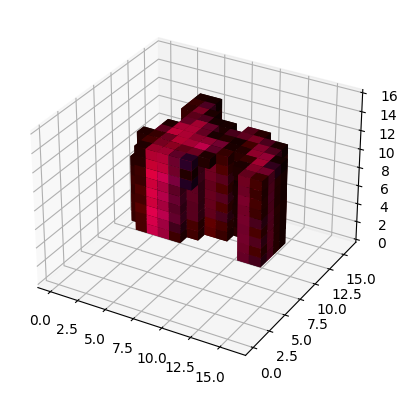

100%|██████████| 3001/3001 [34:57<00:00,  1.43it/s]


In [25]:
test_batch = sample_test()
plot_img(test_batch[0])
f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(3001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_transfer_30000_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [26]:
test_batch = sample_test().cuda()

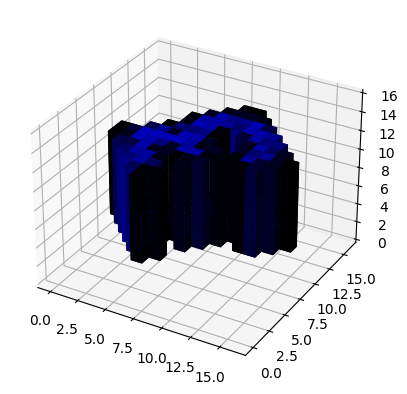

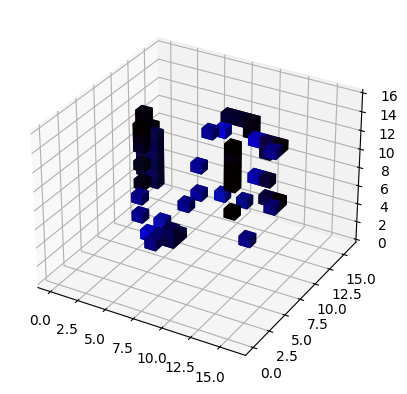

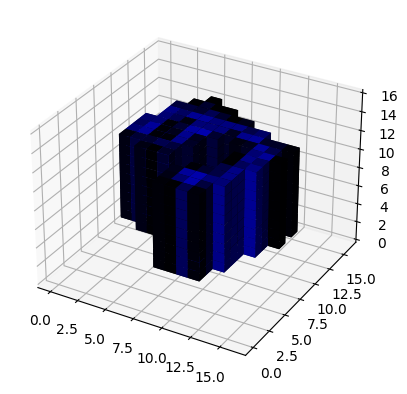

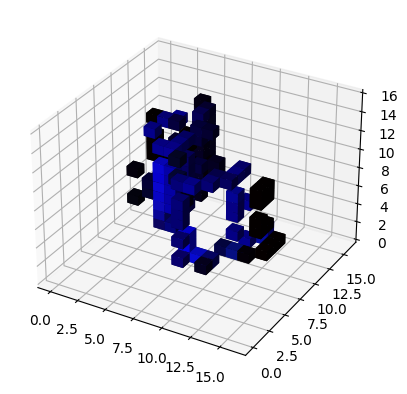

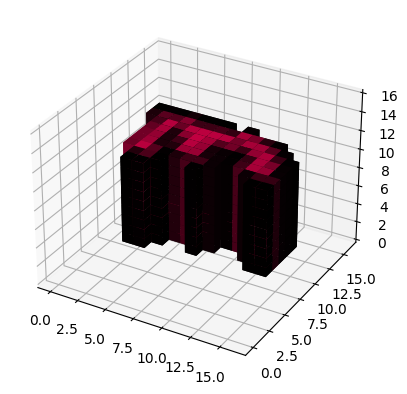

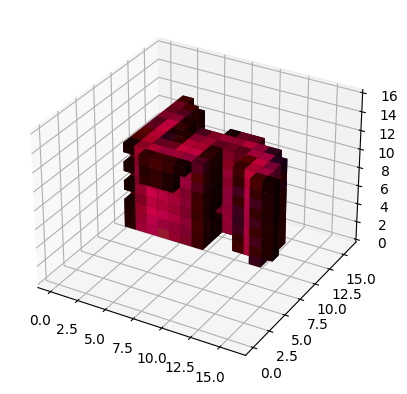

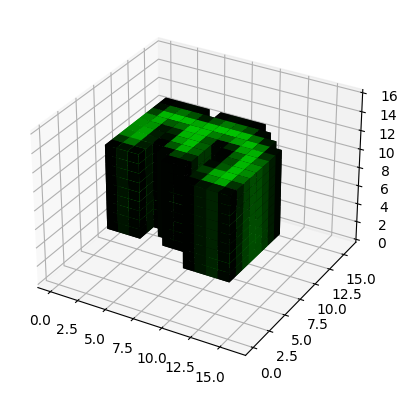

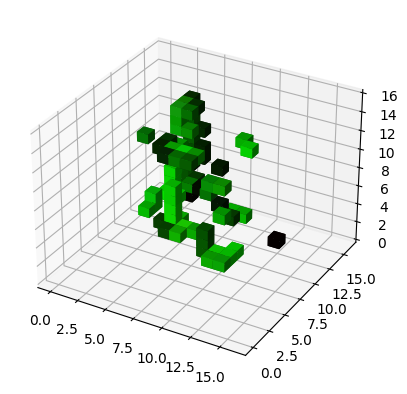

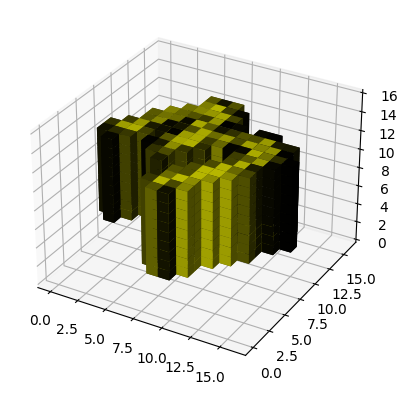

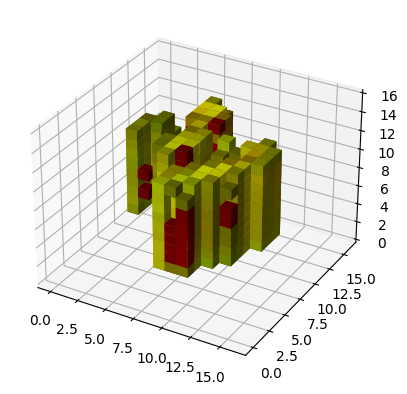

In [27]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)

In [28]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 5 or i > 10:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

def binarize(im):
    return (im > im.max() / 2).to(im.dtype)

TRANSFORM_3D = transforms.Compose([
    # transforms.Resize(16),
    transforms.ToTensor(),
    # binarize,
    # random_color,
    # Add_dimension,
])

# Load train datasets
# mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

x_train_a = np.load(file='./data/x_train_a_c.npy')
mnist_train_a = Colored3DMNIST(x_train_a)

# indices = mnist_train_a.targets == 3
# mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


# mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)
x_train_b = np.load(file='./data/x_train_b_c.npy')
mnist_train_b = Colored3DMNIST(x_train_a)

# indices = mnist_train_b.targets == 5
# mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)
x_test = np.load(file='./data/x_test_c.npy')
mnist_test = Colored3DMNIST(x_test)

# indices = mnist_test.targets == 3
# mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

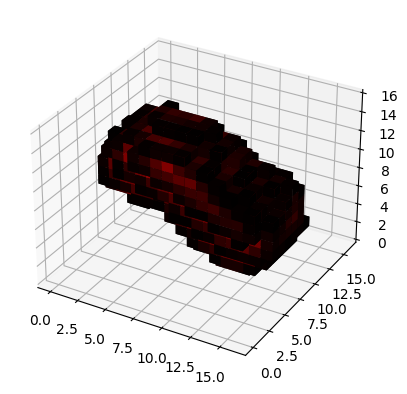

In [29]:
# def plot_img(img):
#     fig = plt.figure()
#     ax = plt.axes(projection="3d")
    
#     ax.voxels(img[0])
#     plt.show()
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


plot_img(next(iter(mnist_loader_test))[0])

In [31]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a).float()
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a).float()

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b).float()
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b).float()

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test).float()
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test).float()

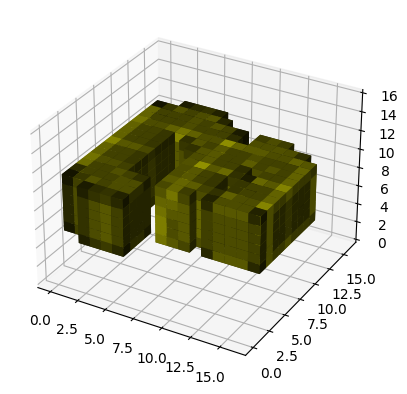

  0%|          | 0/5001 [00:00<?, ?it/s]

T_loss: -9.157022787770457e+25;  f_loss: 4.657673751403146e+24


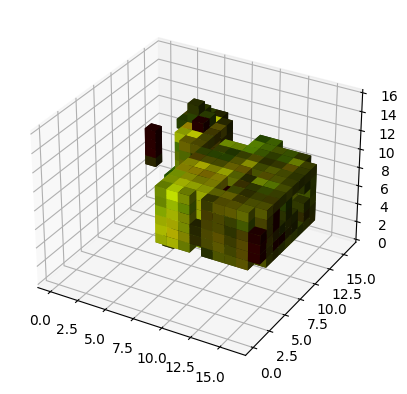

  2%|▏         | 100/5001 [01:08<56:03,  1.46it/s]

T_loss: -9.037934297379403e+25;  f_loss: 7.610351841561465e+24


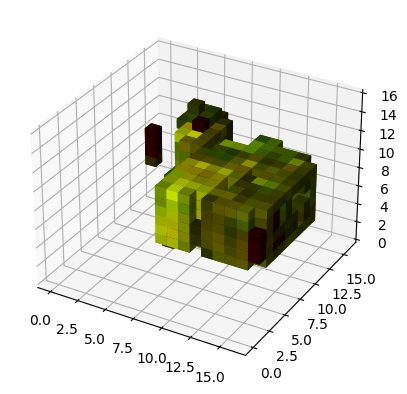

  4%|▍         | 200/5001 [02:18<55:03,  1.45it/s]  

T_loss: -9.786232004752653e+25;  f_loss: 1.2838149888678715e+25


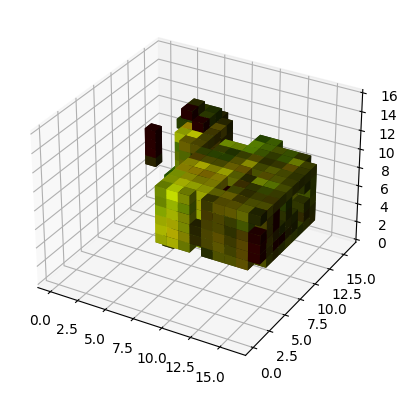

  6%|▌         | 300/5001 [03:27<53:47,  1.46it/s]  

T_loss: -9.43916204902903e+25;  f_loss: 1.2197946412228588e+25


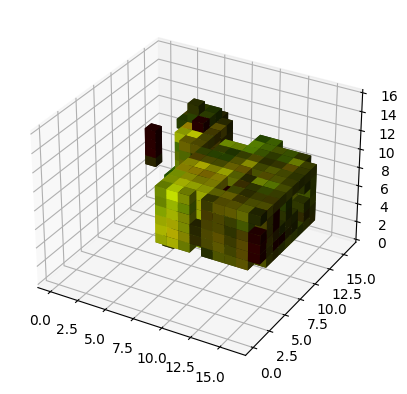

  8%|▊         | 400/5001 [04:36<52:42,  1.45it/s]  

T_loss: -9.46289194060545e+25;  f_loss: 1.5409598342437716e+25


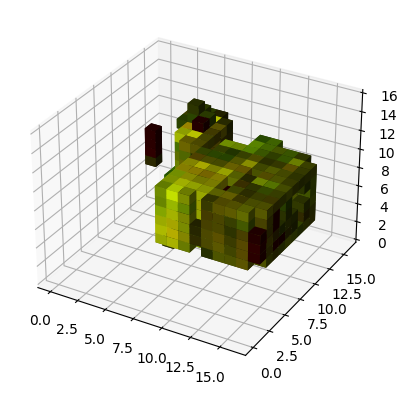

 10%|▉         | 500/5001 [05:45<51:37,  1.45it/s]  

T_loss: -9.954617574006289e+25;  f_loss: 1.2648415902508576e+25


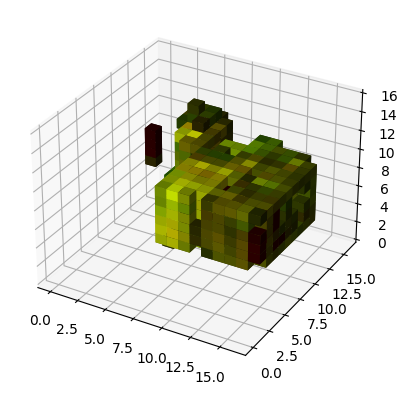

 12%|█▏        | 600/5001 [06:55<50:36,  1.45it/s]  

T_loss: -1.0963830641244105e+26;  f_loss: 9.88636646560797e+24


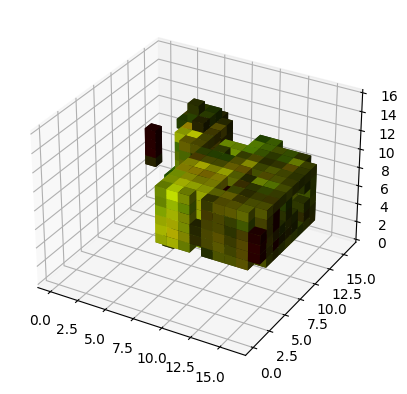

 14%|█▍        | 700/5001 [08:04<49:06,  1.46it/s]  

T_loss: -1.0967587320674716e+26;  f_loss: 1.055952505034578e+25


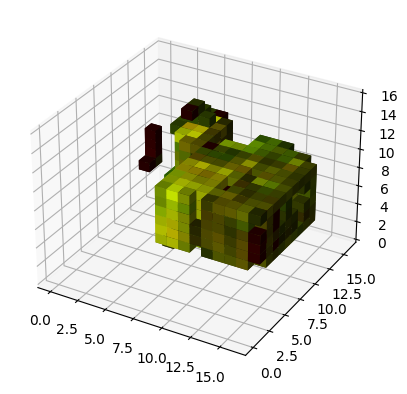

 16%|█▌        | 800/5001 [09:13<48:08,  1.45it/s]

T_loss: -1.0460552734367106e+26;  f_loss: 1.6707575819068178e+25


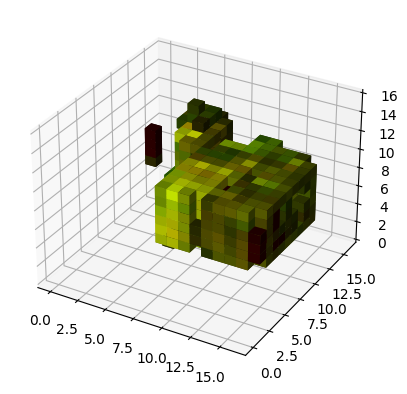

 18%|█▊        | 900/5001 [10:22<46:56,  1.46it/s]

T_loss: -1.07755567148674e+26;  f_loss: 1.4443376334600884e+25


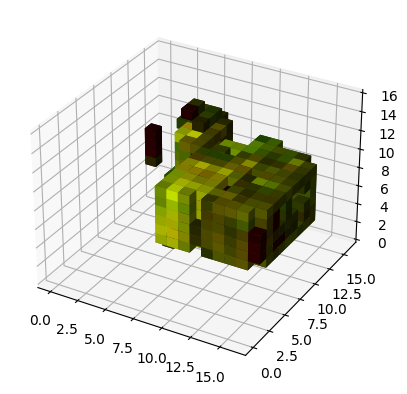

 20%|█▉        | 1000/5001 [11:32<45:52,  1.45it/s]

T_loss: -1.1162498385569142e+26;  f_loss: 1.58536852592682e+25


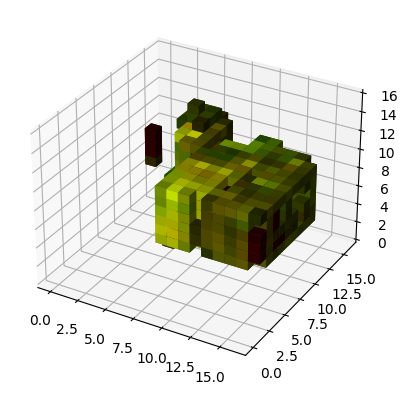

 22%|██▏       | 1100/5001 [12:41<44:43,  1.45it/s]

T_loss: -1.152278820043319e+26;  f_loss: 4.5905737198350273e+24


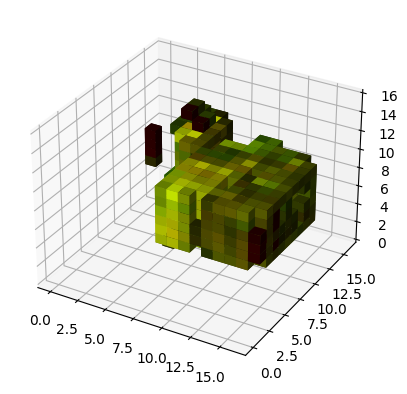

 22%|██▏       | 1122/5001 [12:57<44:47,  1.44it/s]


KeyboardInterrupt: 

In [38]:
test_batch = sample_test()
plot_img(test_batch[0])

f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_transfer_30000_rotated_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)